In [1]:
import numpy as np
import openqcs as o
import openqcs.iterativ as it
import openqcs.spinchain as sp
import openqcs.tools as t

import matplotlib.pyplot as plt

import sys
import os

After $n$ time steps:
- statistical ensamble of states
\begin{equation}
    \vert \psi_\mathbf{p} \rangle = S(\mathbf{p}) \vert i \rangle
\end{equation}

Hence the probability for finding $\vert \psi_\mathbf{p} \rangle$ in the state $\vert l \rangle$ is
\begin{equation}
    P_l (\mathbf{p}) = \vert \langle l \vert \psi_\mathbf{p} \rangle \vert^2. 
\end{equation}

The probability to find the state $\vert \psi_\mathbf{p} \rangle$ is 
\begin{equation}
    P(\mathbf{p})
\end{equation}
and hence the probability for finding both combined is
\begin{equation}
    P(\mathbf{p}) P_l (\mathbf{p}).
\end{equation}

The total probability for measuring $\vert l \rangle$ is 
\begin{equation}
    P_l = \int_{\mathbf{p} \in \{0,1\}^n} d[\mathbf{p}] P(\mathbf{p}) \vert \langle l \vert \psi_\mathbf{p} \rangle \vert^2
\end{equation}

#########################################################
valid time steps:  56
[0, 38]


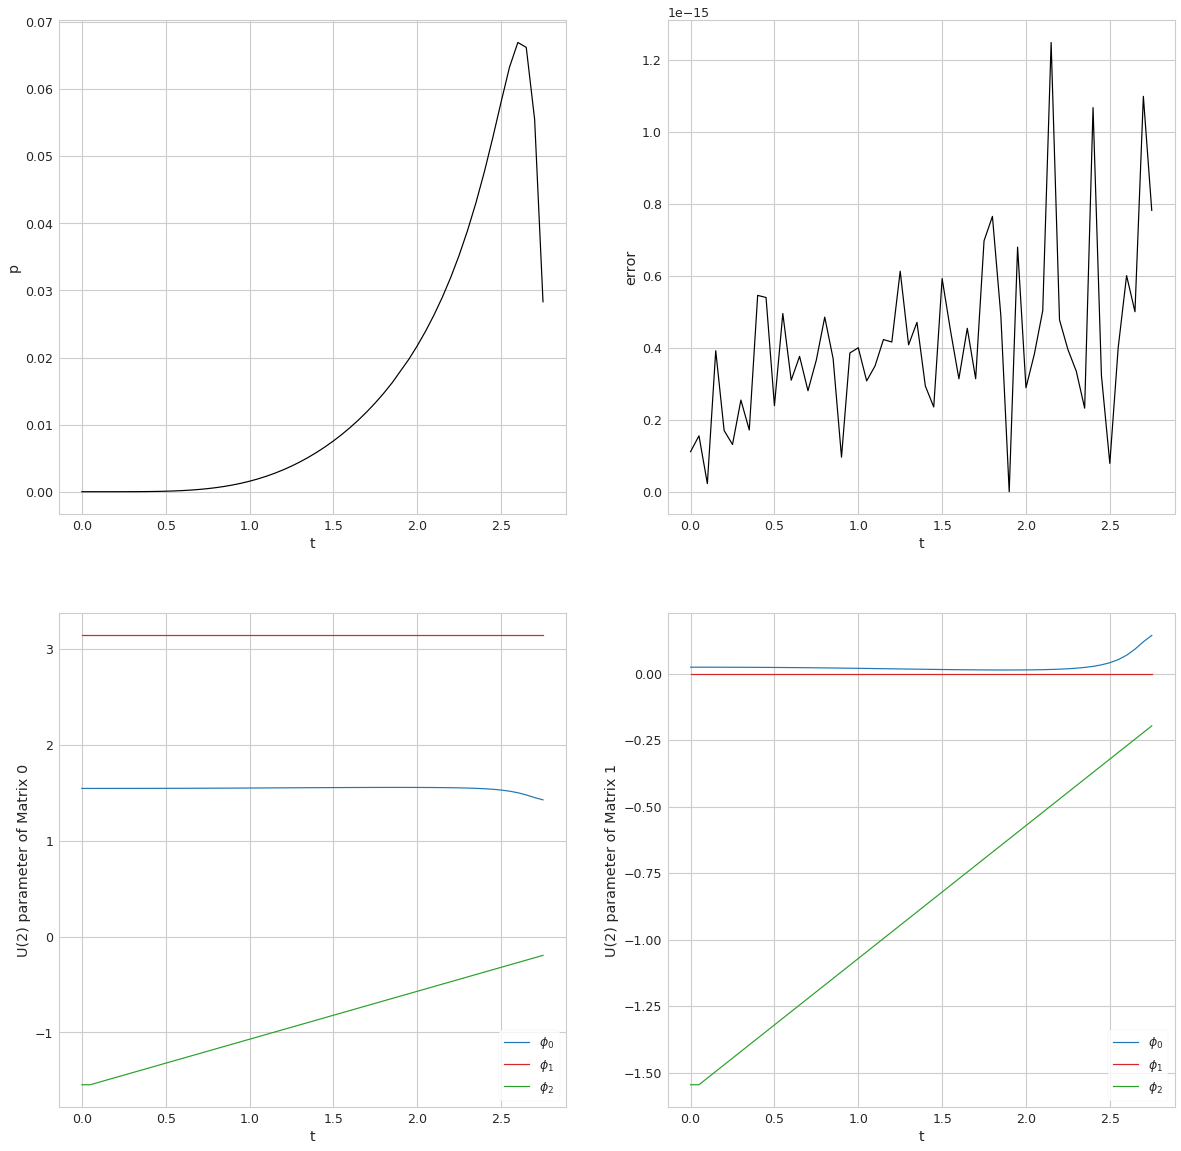

In [2]:
def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t

data, n_t = get_data(0.5, 0.5, 0.05, plotting=True)

## Note for Bug Fixing:

For $dt = 0.1$ the pseudo Kraus operator are not special, i.e. $\det{E_i} \neq 1$. Hence the algorithm does not work for these ranges

#########################################################################################################################################################
valid time steps:  152
[0, 81]
#

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


#

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: ComplexWarning: Casting complex values to real discards the imaginary part


######################################################################################################################################################

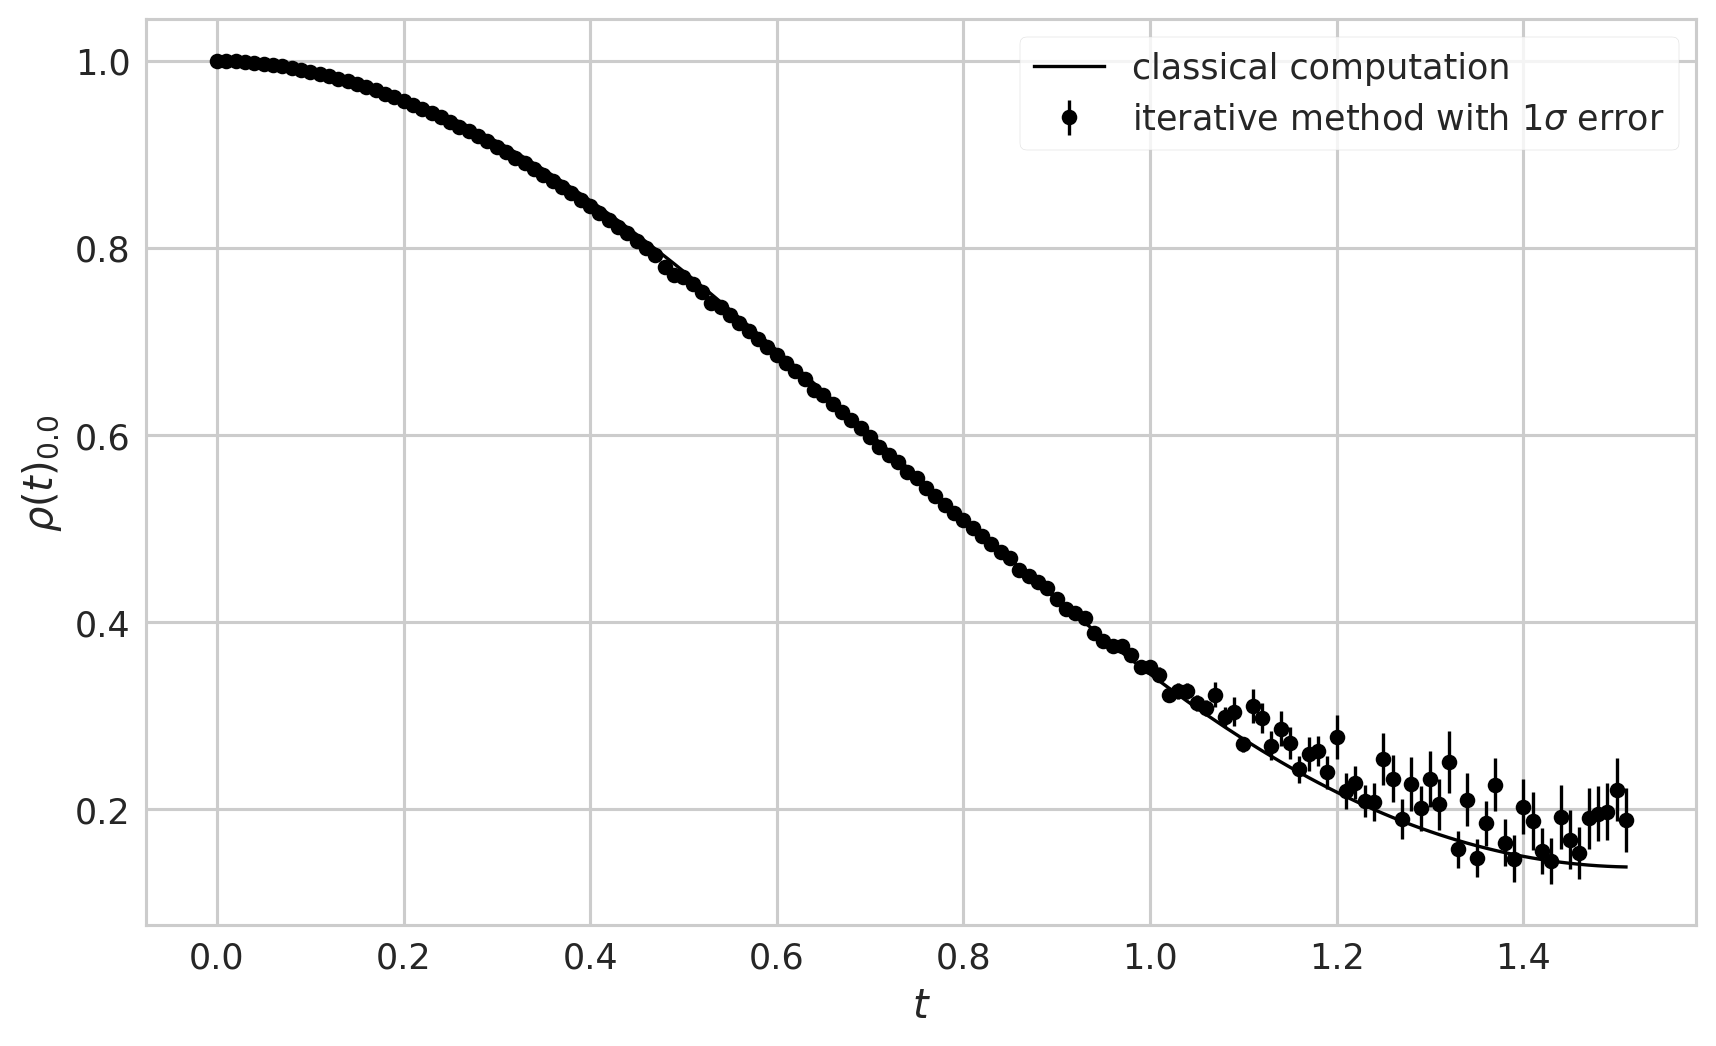

In [12]:
import pyqcs
import openqcs.qcirc as qu
import openqcs.statistic as st

def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t

def QuantumEvolution(data, n_sample, iSt=pyqcs.State.new_zero_state(1), n_measure=100, log=False,
                     filename=""):
    
    if log==True and filename=="":
        path = "./QuEvoData"
        if not os.path.exists(path):
            os.makedirs(path)
            
        filename=path+"/data.txt"
        
    
    probs = data[:,0]
    """
    circs = np.ndarray((probs.shape[0],2), dtype=pyqcs.AnonymousCompoundGateCircuit)

    for i, d in enumerate(data):
        c1 = qu.su2_to_circuit(0, d[1:4])
        c2 = qu.su2_to_circuit(0, d[4:])
        circs[i,:] = [c1, c2]
    """    
        
    output = np.zeros((n_sample, 2), dtype=float)
    
    
    for i in range(n_sample):
        
        #evolute_gates = np.ndarray(probs.shape[0], dtype=pyqcs.AnonymousCompoundGateCircuit)
        path=""
        
        M = np.matrix(np.eye(2), dtype=np.complex)
        
        for k, p in enumerate(probs):
            
            q = np.random.rand()
            if q < p:
                #evolute_gates[k] = circs[k,0]
                M*=(t.su2(data[k,1:4])).H
                path+="0"
            else:
                #evolute_gates[k] = circs[k,1]
                M*=(t.su2(data[k,4:])).H
                path+="1"
        
        psi = iSt
        """
        for gate_ in evolute_gates:
            psi = gate_*psi
        """
        #print(path)
        circ = qu.su2_to_circuit(0,t.get_su2_param(M.H))
        psi = circ * psi
        res = pyqcs.sample(psi, 1, n_measure)
        
        
        for j,val in enumerate(psi._qm_state):
            output[i,j] = np.double(val*np.conj(val))
            
    
    
    if log:   
        file = open(filename, "w")
    
        for o in output:
            file.write("{}\t{}\n".format(o[0], o[1]))
            
        file.close()
    
    #mean0 = np.mean(output[:,0])
    #mean1 = np.mean(output[:,1])
    
    #err0 = np.std(output[:,0])
    #err1 = np.std(output[:,1])
    mean0, err0 = st.bootstrap(output[:,0], n_boot=100)
    mean1, err1 = st.bootstrap(output[:,1], n_boot=100)
   
    
    return mean0, err0, mean1, err1

def ClassicalEvolution(idx, T, rho0):
    
    rho = o.rho_sys_(T**idx, rho0)
    
    return rho[0,0], rho[1,1]
        
    

def main(saving=False, plotting=True):
    a = 0.5
    b = 1.0
    dt = 0.01
    
    n_sample = 100
    
    data, n_t = get_data(a,b,dt)
    
    t_data = np.arange(n_t) * dt
    qc_prob = np.zeros((n_t, 2,2), dtype=np.double)
    cl_prob = np.zeros((n_t, 2), dtype=np.double)
    
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    
    path = "./QuEvoData"
    if not os.path.exists(path):
        os.makedirs(path)

    
    
    iSt = pyqcs.State.new_zero_state(1)
    rho0 = np.matrix([[1,0],[0,0]])
    for i in range(n_t):
        print("#", end="", flush=True)
        #print("t = ", i*dt, "\n")
        m0, e0, m1, e1 = QuantumEvolution(data[:i+1], n_sample, iSt=iSt, log=False, 
                                          filename=path+"/t_{0:.2f}.txt".format(i*dt))
        qc_prob[i,:,:] = [[m0, e0], [m1, e1]]
        
        r0, r1 = ClassicalEvolution(i, T, rho0)
        cl_prob[i,:] = [r0, r1]
        
    if plotting:
        
        colors = ["black", "tab:orange"]
        
        plt.figure(figsize=(10,6), dpi=200)
        
        plt.plot(t_data, cl_prob[:,0], color=colors[0], label="classical computation")
        plt.errorbar(t_data, qc_prob[:,0,0], yerr=qc_prob[:,0,1], 
                    color=colors[0], fmt="o", label="iterative method with "+"$1\sigma$"+" error")
            
        plt.legend()
        plt.xlabel("$t$")
        plt.ylabel(r"$\rho(t)_{0.0}$")
        plt.savefig("iterative_method_spin_chain.png", format="png")
        plt.show()
        
main()
        
        
    


##########################################################################################################################################################################################################################################################################################
valid time steps:  281
[0, 190]
#####

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: ComplexWarning: Casting complex values to real discards the imaginary part


####################################################################################################################################################################################################################################################################################

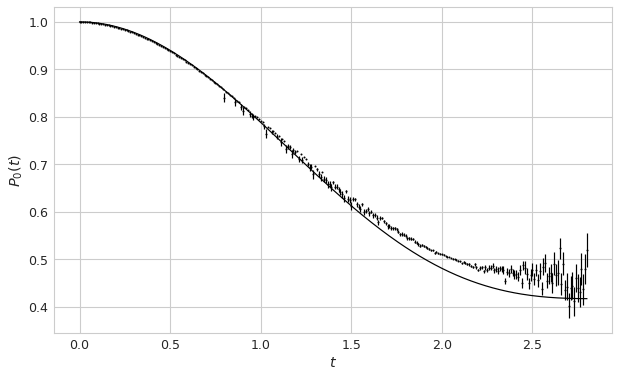

In [8]:
import pyqcs
import openqcs.qcirc as qu
import openqcs.statistic as st

class Path:
    def __init__(self, data):
        self.path = np.ones(data.shape[0], dtype=int)
        self.probs = data[:,0]
        self.size = data.shape[0]
        self.param0 = data[:,1:4]
        self.param1 = data[:,4:]
        
    def get_prob(self):
        val = 1.0
        for x, prob in zip(self.path, self.probs):
            if x==1:
                val*=(1-prob)
            else:
                val*=prob
                
        return val
    
    def diff_prob(self, idx):
        if self.path[idx] == 1:
            pj = self.probs[idx]
        else:
            pj = 1-self.probs[idx]
        
        return pj/(1-pj)
    
    def get_cirucit(self):
        
        S = np.matrix(np.eye(2), dtype=np.complex)
        for i,p in enumerate(self.path):
            if p == 0:
                S=t.su2(self.param0[i,:])@S
            elif p == 1:
                S=t.su2(self.param1[i,:])@S
            else:
                raise ValueError()
                
        paramS = t.get_su2_param(S)
        circ = qu.su2_to_circuit(0, paramS)
        return circ
    
    def measure(self, iSt):
        circ = self.get_cirucit()
        psi = circ*iSt
        
        # if working, replace by real measurement
        return np.array([a*np.conj(a) for a in psi._qm_state])
    
    def print(self, reduced=False):
        path_str = ""
        for p in self.path:
            path_str+="{}".format(p)
            
        if not reduced:
            print(path_str, "\t", self.get_prob())
        else:
            if "0" in path_str:
                print(path_str, "\t", self.get_prob())



def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t



def sweep(path):
    for i in range(path.size):
        dp = path.diff_prob(i)
        if dp < 1:
            q = np.random.rand()
            if q < dp:
                path.path[i] = (path.path[i]+1)%2
        else:
            path.path[i] = (path.path[i]+1)%2
            
    return path
"""
def noise(path, n_sample=100, iSt):
    data_noise = np.zeros((n_sample,2),dtype=float)
    for i in range(n_sample):
        p = path.get_prob()
        data_noise[i,:] = path.measure(iSt)
        
    return [st.bootstrap(data_noise[:,k]) for k in range(2)]
"""     
            
    
    


def QuantumEvolution(data, n_sample, iSt=pyqcs.State.new_zero_state(1), n_measure=100, log=False,
                     filename=""):
    
    if log==True and filename=="":
        path = "./QuEvoData"
        if not os.path.exists(path):
            os.makedirs(path)
            
        filename=path+"/data.txt"
        
    
        
    output = np.zeros((n_sample, 2), dtype=float)
    
    path=Path(data)
    
    for i in range(n_sample):
        
        path = sweep(path)
        #path.print(reduced=True)
        output[i,:] = path.measure(iSt)
        
    
    
    if log:   
        file = open(filename, "w")
    
        for o in output:
            file.write("{}\t{}\n".format(o[0], o[1]))
            
        file.close()
    
    mean0, err0 = st.bootstrap(output[:,0], n_boot=100)
    mean1, err1 = st.bootstrap(output[:,1], n_boot=100)
   
    
    return mean0, err0, mean1, err1
    

def main(saving=False, plotting=True):
    a = 0.5
    b = 0.5
    dt = 0.01
    
    n_sample = 100
    
    data, n_t = get_data(a,b,dt)
    
    t_data = np.arange(n_t) * dt
    qc_prob = np.zeros((n_t, 2,2), dtype=np.double)
    cl_prob = np.zeros((n_t, 2), dtype=np.double)
    
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    
    path = "./QuEvoData"
    if not os.path.exists(path):
        os.makedirs(path)

    
    
    iSt = pyqcs.State.new_zero_state(1)
    rho0 = np.matrix([[1,0],[0,0]])
    for i in range(n_t):
        print("#", end="", flush=True)
        #print("t = ", i*dt, "\n")
        m0, e0, m1, e1 = QuantumEvolution(data[:i+1], n_sample, iSt=iSt, log=False, 
                                          filename=path+"/t_{0:.2f}.txt".format(i*dt))
        qc_prob[i,:,:] = [[m0, e0], [m1, e1]]
        
        r0, r1 = ClassicalEvolution(i, T, rho0)
        cl_prob[i,:] = [r0, r1]
        
    if plotting:
        
        #colors = ["tab:blue", "tab:orange"]
        
        plt.figure(figsize=(10,6))
        
        
    
        plt.plot(t_data, cl_prob[:,0], color="black")
        plt.errorbar(t_data, qc_prob[:,0,0], yerr=qc_prob[:,0,1], 
                    color="black", fmt="o", markersize=2)
            
        #plt.legend()
        plt.xlabel("$t$")
        plt.ylabel(r"$P_0(t)$")    
        plt.show()
        
main()
        

###############################
valid time steps:  30
[0, 16]
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
i =  0	 time:  0.004814624786376953
i =  1	 time:  0.005051612854003906
i =  2	 time:  0.009162425994873047
i =  3	 time:  0.015642881393432617
i =  4	 time:  0.030894756317138672
i =  5	 time:  0.0722970962524414
i =  6

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: ComplexWarning: Casting complex values to real discards the imaginary part


	 time:  0.08839702606201172
i =  7	 time:  0.1159064769744873
i =  8	 time:  0.2547569274902344
i =  9	 time:  0.5582196712493896
i =  10	 time:  1.2918424606323242
i =  11	 time:  2.3396155834198
i =  12	 time:  3.7740118503570557
i =  13	 time:  8.647990942001343
i =  14	 time:  15.69818663597107
i =  15	 time:  31.394672632217407
i =  16	 time:  63.675121784210205


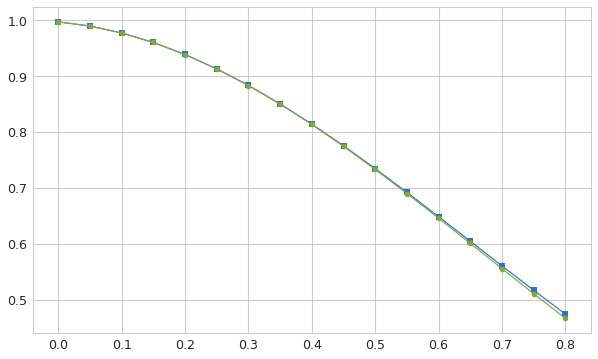

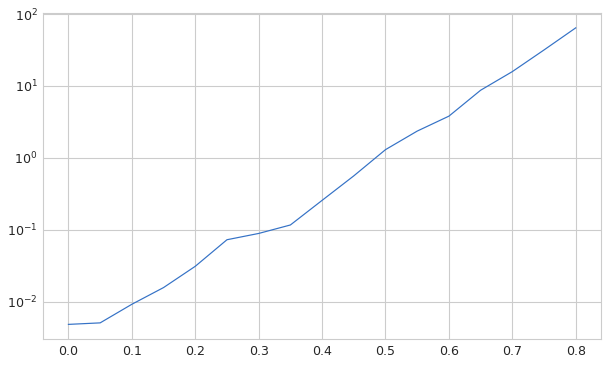

In [5]:
import time

def QuantumEvolutionFull(data, n_t, iSt=pyqcs.State.new_zero_state(1), n_measure=100):
    
    N = 2**n_t 
    val0 = 0
    val1 = 1
    
    P = data[:,0]
    S0 = [t.su2(data[i,1:4]) for i in range(data.shape[0])]
    S1 = [t.su2(data[i,4:]) for i in range(data.shape[0])]
    
    for n in range(N):
        bn = "{0:b}".format(n)
        while len(bn)!=n_t:
            bn = "0"+bn
            
        E = np.matrix(np.eye(2))
        q = 1.0
        for i,site in enumerate(bn):
            if site == "0":
                E=S0[i]*E
                q*=P[i]
            else:
                E=S1[i]*E
                q*=(1-P[i])
                
        circ = qu.su2_to_circuit(0,t.get_su2_param(E))
        
        psi = circ*iSt
        
        tmp0, tmp1 = [a * np.conj(a) for a in psi._qm_state]
        
        
        val0 += tmp0*q
        val1 += tmp1*q
        
    return val0, val1
                
        
                
        
        
        
def main():
    a = 0.5
    b = 1.0
    dt = 0.05
    
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    
    data, n_t = get_data(a,b,dt)
    n_tmax = 17
    
    iSt = pyqcs.State.new_zero_state(1)
    iStvec = np.matrix([a for a in iSt._qm_state]).H
    rho0 = iStvec @ iStvec.H
    print(rho0)
    
    qm_evo = np.zeros((n_tmax,2),dtype=float)
    cl_evo = np.zeros((n_tmax,2),dtype=float)
    times = []
    for i in range(n_tmax):
        print("i = ", i, end="")
        t_st = time.time()
        v0, v1 = QuantumEvolutionFull(data, i+1)
        t_end = time.time()
        print("\t time: ", t_end - t_st)
        times.append(t_end-t_st)
        r0, r1 = ClassicalEvolution(i+1, T, rho0)
        
        qm_evo[i,:]=[v0,v1]
        cl_evo[i,:]=[r0,r1]
        
    
    tarray = np.arange(n_tmax)*dt
    return qm_evo, cl_evo, tarray,times
        
        
    
qm_evo, cl_evo, tarray,times = main()

plt.figure(figsize=(10,6))
plt.plot(tarray, qm_evo[:,0], "s-", label=r"$\vert 0 \rangle$")
plt.plot(tarray, cl_evo[:,0], "o-", label=r"$\vert 1 \rangle$")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(tarray, times)
plt.yscale("log")
plt.show()

In [39]:
2**30

1073741824